# How To Become A Successful Hip-Hop Singer? Who's The Next Eminem?

![Hiphop](https://i.pinimg.com/originals/29/a0/d9/29a0d9f43e2cad8bf4d360f812449abb.jpg)

In [1]:
import numpy as np
import pandas as pd
import pyreadr
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import cv2
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

In [2]:
"""
Load processed lyrics data
"""

def read_processed_lyrics() -> pd.DataFrame:
    """
    Load processed lyrics data from file
    
    return the data frame containing the data
    """
    result = pyreadr.read_r('../output/processed_lyrics.RData')
    return result['dt_lyrics']

lyrics_df = read_processed_lyrics()

## Data Preprocessing

In [3]:
"""
Check null value
"""
lyrics_df.info()

lyrics_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125704 entries, 0 to 125703
Data columns (total 7 columns):
song            125704 non-null object
year            125704 non-null float64
artist          125704 non-null object
genre           125704 non-null object
lyrics          125704 non-null object
id              125704 non-null int32
stemmedwords    125704 non-null object
dtypes: float64(1), int32(1), object(5)
memory usage: 6.2+ MB


,song,year,artist,genre,lyrics,id,stemmedwords
0,when-you-were-with-me,2009.0,a,Hip-Hop,I stopped by the house we called our home\nIt ...,1,stop house call home rundown grass overgrown s...
1,careless-whisper,2009.0,a,Hip-Hop,I feel so unsure\nAs I take your hand and lead...,2,unsure hand lead dance floor music die eyes ca...
2,2-59,2007.0,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...,3,mark sunday football boots pitch people gamble...
3,power-of-desire,2007.0,a,Hip-Hop,[Chris:] Fallin' for a fantasy\nI threw away m...,4,chris fallin fantasy threw destiny stop feelin...
4,you-re-not-in-love,2007.0,a,Hip-Hop,something in the way we touch\nyou hold my han...,5,touch hold hand hold somethings change somethi...


In [4]:
lyrics_df.describe()

,year,id
count,125704.000000,125704.000000
mean,2006.798272,62858.362892
std,8.525775,36291.223577
min,112.000000,1.000000
25%,2006.000000,31428.750000
50%,2007.000000,62859.500000
75%,2008.000000,94287.250000
max,2016.000000,125715.000000


In [5]:
"""
Correct wrong year value
"""
lyrics_df.loc[64356,'year'] = 2002
lyrics_df.loc[91130,'year'] = 1999

In [6]:
"""
Counting the number of tokens in each song
"""
def words_count(raw_text):
    return len(raw_text.split())

lyrics_df['word_count'] = lyrics_df['lyrics'].apply(words_count)
lyrics_df.head()

,song,year,artist,genre,lyrics,id,stemmedwords,word_count
0,when-you-were-with-me,2009.0,a,Hip-Hop,I stopped by the house we called our home\nIt ...,1,stop house call home rundown grass overgrown s...,107
1,careless-whisper,2009.0,a,Hip-Hop,I feel so unsure\nAs I take your hand and lead...,2,unsure hand lead dance floor music die eyes ca...,300
2,2-59,2007.0,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...,3,mark sunday football boots pitch people gamble...,369
3,power-of-desire,2007.0,a,Hip-Hop,[Chris:] Fallin' for a fantasy\nI threw away m...,4,chris fallin fantasy threw destiny stop feelin...,147
4,you-re-not-in-love,2007.0,a,Hip-Hop,something in the way we touch\nyou hold my han...,5,touch hold hand hold somethings change somethi...,125


1. Trend of words
    1. Overall trend
    2. Trend in Hip-Hop
2. Difference between Hip-hop and other genres
    1. word cloud
    2. sentiment analysis
    3. profane words(optional)
3. Is Eminem unique?
    1. Most common words Comparison
    2. Amount of Unique Words
    3. Average Words Count --> Speech Speed

* Other topics can be done: 
    1. Number of personal pronouns
    2. More fine-grained sentiment analysis

## Question1. Does the trend of words change with time?

In [7]:
"""
Get all lyrics for each decades

store the lyrics string for all genre and only Hip-Hop

"""
def get_subdata_by_period(dataframe, start_year, end_year, genre) -> pd.DataFrame:
    """
    return the subset of dataframe whose 'year' are in the range 
    from 'start_year'(inclusive) to 'end_year'(exclusive)
    """
    start_condition = dataframe['year'] >= start_year if start_year else True
    end_condition = dataframe['year'] < end_year if end_year else True
    genre_condition = True if genre is None or genre == 'all' else dataframe['genre'] == genre

    return dataframe[start_condition & end_condition & genre_condition]
    
    
def combine_lyrics(dataframe, use = 'stemmedwords') -> str:
    """
    return a string that contains all lyrics in the dataframe
    """
    lyrics_list = []

    for index, row in dataframe.iterrows():
        lyrics_list.append(row[use])
    return " ".join(lyrics_list)


def get_stemmed_lyrics_by_decades(dataframe, genre = None):
    """
    return a dictionary containing all lyrics as strings
    the key is decade, value is the lyrics string
    
    if genre is None or 'all', then the lyrics containing lyrics for all genre
    otherwise it's only from a specific genere
    """
    lyrics_dict = {}
    lyrics_dict["70"] = combine_lyrics(get_subdata_by_period(dataframe,None, 1980, genre))
    lyrics_dict["80"] = combine_lyrics(get_subdata_by_period(dataframe,1980, 1990, genre))
    lyrics_dict["90"] = combine_lyrics(get_subdata_by_period(dataframe,1990, 2000, genre))
    lyrics_dict["00"] = combine_lyrics(get_subdata_by_period(dataframe,2000, 2010, genre))
    lyrics_dict["10"] = combine_lyrics(get_subdata_by_period(dataframe,2010, None, genre))
    return lyrics_dict


In [8]:
"""
Combine all lyrics together
"""
lyrics_all_dict = get_stemmed_lyrics_by_decades(lyrics_df,genre = 'all')
lyrics_hiphop_dict = get_stemmed_lyrics_by_decades(lyrics_df,genre = 'Hip-Hop')

In [9]:
"""
Functions for drawing word clouds
"""
def get_stopwords():
    """
    return a 'set' containing all stop words
    """
    english_stopwords =set(stopwords.words('english')) | STOPWORDS | ENGLISH_STOP_WORDS | set(['a','yeah', 'ah', 'aa', 'aaa','aaaa'])
    english_stopwords.add('youre')
    english_stopwords.add('ill')
    english_stopwords.add('youll')
    english_stopwords.add('ive')
    english_stopwords.add('youve')
    english_stopwords.add('shes')
    english_stopwords.add('hes')
    english_stopwords.add('ya')
    english_stopwords.add('yo')
    english_stopwords.add('em')
    english_stopwords.add('yall')
    english_stopwords.add('gotta')
    return english_stopwords
def color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    """
    Color function for word cloud
    """
    h =  random_state.randint(30,50) # int(360.0 * 21.0 / 255.0)
    s =  100 #random_state.randint(20,100)  #int(100.0 * 255.0 / 255.0)
    l = random_state.randint(0, 80)

    return "hsl({}, {}%, {}%)".format(h, s, l)


def draw_wordCloud(subplot, natural_text, params = {}):
    """
    draw the word cloud plot for the 'natural_text' provided, on the 'subplot'
    """
    title = params.get('title', None)
    max_words = params['max_words'] if 'max_words' in params else 30 
    titlefontsize = params.get('titlefontsize', 30)
    bgc = params['bgc'] if 'bgc' in params else 'white'
    
    # stop words
    english_stopwords = get_stopwords()
    # generate wordcloud
    wordcloud = WordCloud(background_color = bgc, 
                          max_words=max_words, 
                          stopwords=english_stopwords,
                          collocations=False,
                          color_func= color_func,
                          random_state= 13
                         ).generate(natural_text)
                
    subplot.imshow(wordcloud)
    subplot.axis("off")
    if title:
        subplot.set_title(title, size=titlefontsize)
        subplot.title.fontweight = 'bold'


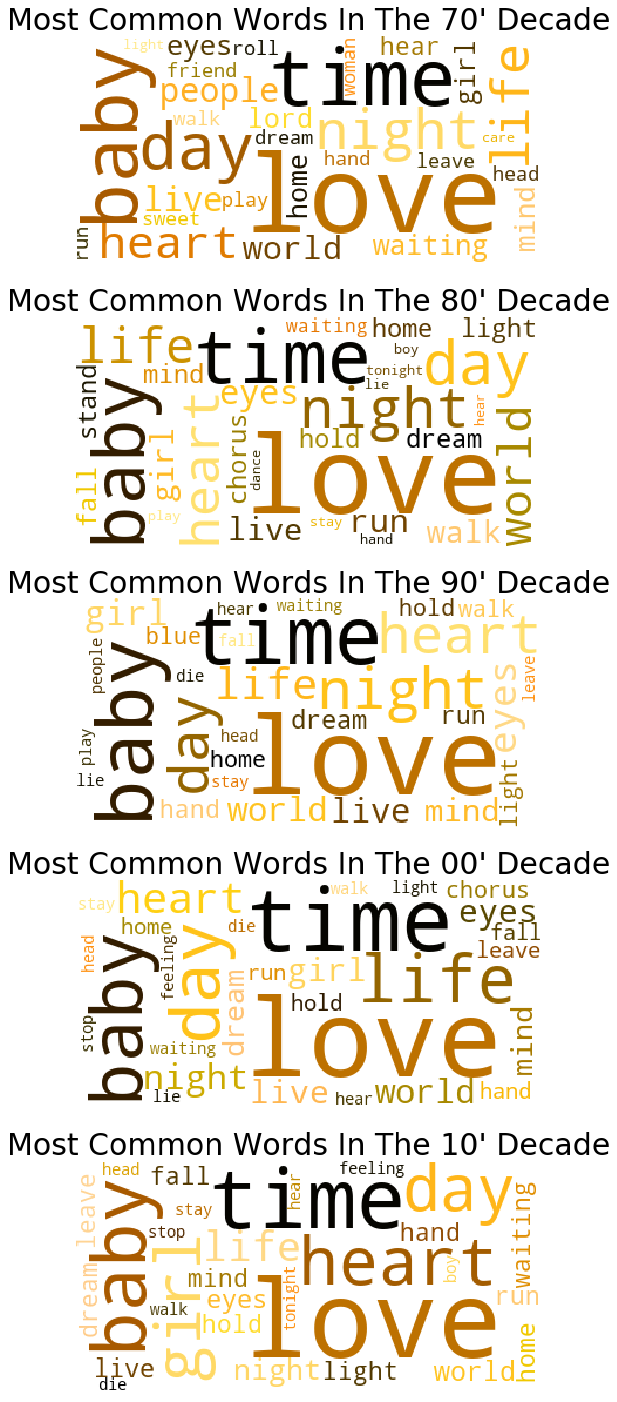

In [10]:
"""
word cloud plot for all genres
"""
fig, axs = plt.subplots(5,1, figsize = (20,25))
decades = ['70','80','90','00', '10']
title_template = "Most Common Words In The {0}' Decade"

for subplot, dec in zip(axs, decades):
    draw_wordCloud(subplot, lyrics_all_dict[dec], params = {
        'title' : title_template.format(dec),
        'max_words' : 30,
        'titlefontsize' : 30,
    })

plt.show()

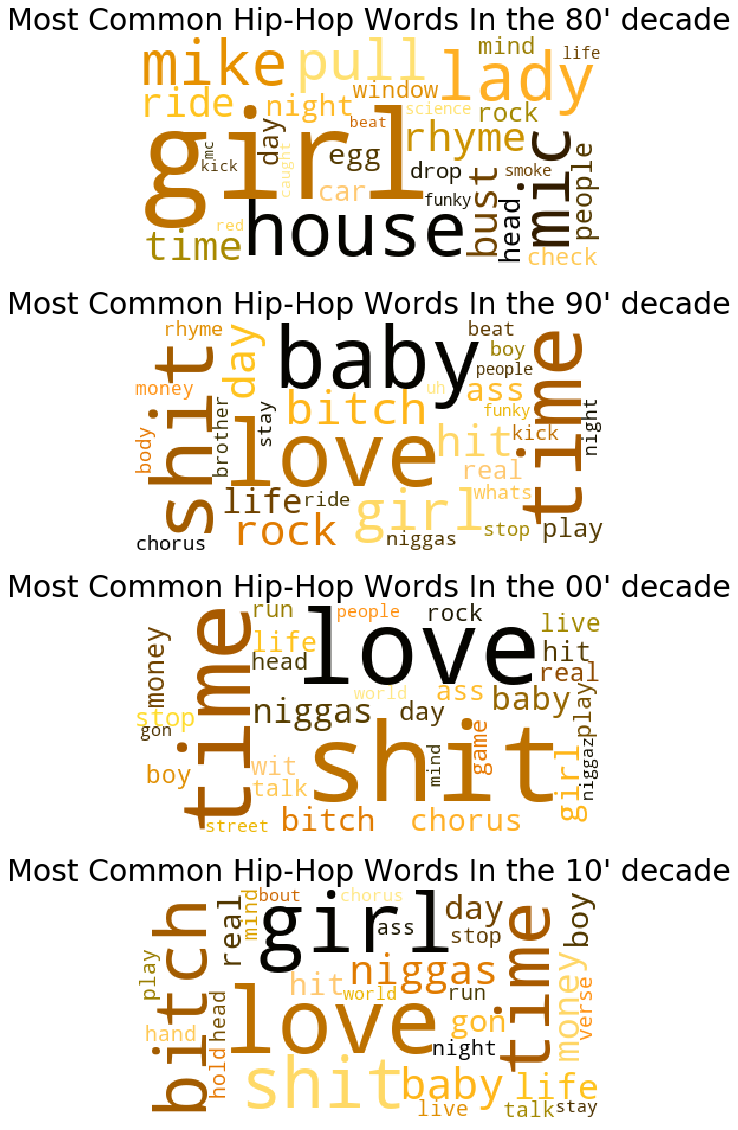

In [11]:
"""
word cloud plot for Hip-Hop
"""
fig, axs = plt.subplots(4,1, figsize = (16,20))
decades = ['80','90','00', '10']
title_template = "Most Common Hip-Hop Words In the {0}' decade"
for subplot, dec in zip(axs, decades):
    draw_wordCloud(subplot, lyrics_hiphop_dict[dec], params = {
        'title' : title_template.format(dec),
        'titlefontsize' : 30,
        'max_words' : 30
    })
plt.show()

## Question2. Are there any differences between Hip-hop and other genres?

### Part1. Most Common Words

In [12]:
"""
Get all lyrics for hiphop and others
"""
hiphop_df = lyrics_df[lyrics_df['genre'] == 'Hip-Hop']
nonhiphop_df = lyrics_df[lyrics_df['genre'] != 'Hip-Hop']

stemmed_lyrics_hiphop = combine_lyrics(hiphop_df)
stemmed_lyrics_non_hiphop = combine_lyrics(nonhiphop_df)

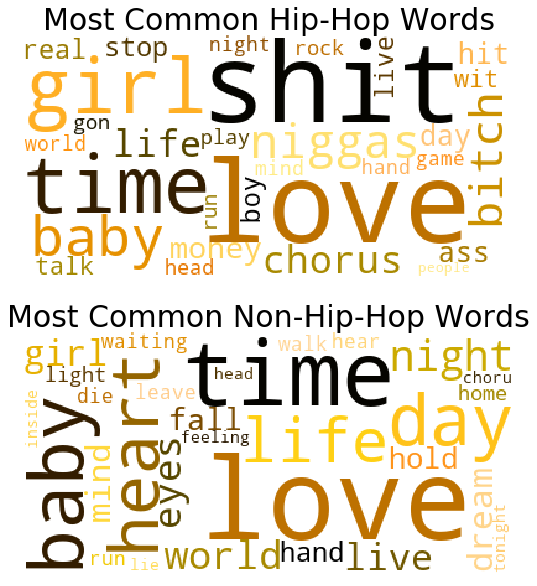

In [13]:
fig, axs = plt.subplots(2,1, figsize = (16,10))

draw_wordCloud(axs[0], stemmed_lyrics_hiphop, params = {
    'title' : 'Most Common Hip-Hop Words',
    'titlefontsize' : 30,
    'max_words' : 30
})

draw_wordCloud(axs[1], stemmed_lyrics_non_hiphop, params = {
    'title' : 'Most Common Non-Hip-Hop Words',
    'titlefontsize' : 30,
    'max_words' : 30
})
plt.show()

In [14]:
"""
Frequent Words plot
"""
stemmed_lyrics_hiphop_tokens = nltk.tokenize.word_tokenize(stemmed_lyrics_hiphop)
hiphop_fdist = nltk.FreqDist(stemmed_lyrics_hiphop_tokens)

stemmed_lyrics_non_hiphop_tokens = nltk.tokenize.word_tokenize(stemmed_lyrics_non_hiphop)
non_hiphop_fdist = nltk.FreqDist(stemmed_lyrics_non_hiphop_tokens)

In [15]:
def get_top_frequent_words(frequency_dist, number = 20):
    stopwords = get_stopwords()
    top_frequency_list = sorted(frequency_dist, key=frequency_dist.get, reverse=True)
    # record the top words and their frequency
    top_words = []
    top_words_frequency = []
    for word in top_frequency_list:
        if len(top_words) == 20:
            break
        if word in stopwords:
            continue
        top_words.append(word)
        top_words_frequency.append(frequency_dist[word])
    return top_words, top_words_frequency
    
    

def draw_word_frequency(subplot, words, frequency, params = {}):
    
    title = params.get("title", None)
    title_fontsize = params.get("titlefontsize", 30)
    yfontsize = params.get('yfontsize', 12)
    xfontsize = params.get('xfontsize', 16)
    subplot.invert_yaxis()
    subplot.set_title(title, size = title_fontsize)
    subplot.barh(words, frequency)


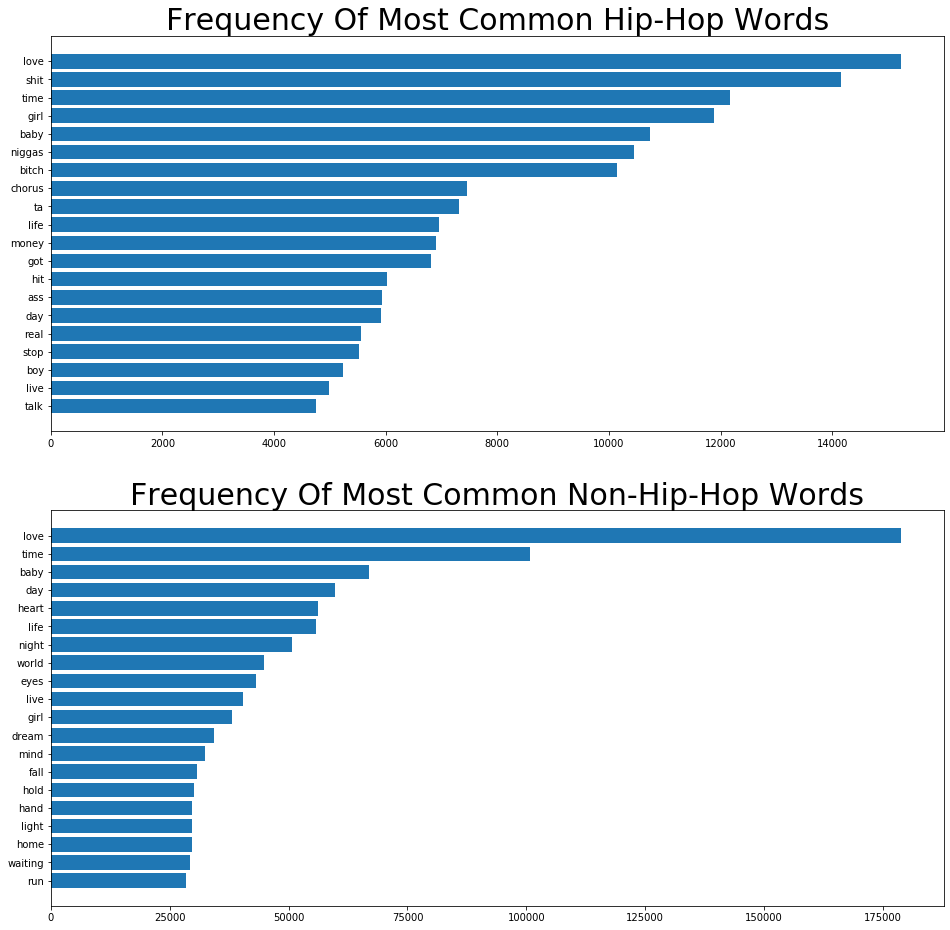

In [16]:
fig, axs = plt.subplots(2,1, figsize = (16, 16))
hiphop_top_words, hiphop_top_words_frequency = get_top_frequent_words(hiphop_fdist)
non_hiphop_top_words, non_hiphop_top_words_frequency = get_top_frequent_words(non_hiphop_fdist)

draw_word_frequency(axs[0], hiphop_top_words, hiphop_top_words_frequency, params = {
    'title': 'Frequency Of Most Common Hip-Hop Words'
})
draw_word_frequency(axs[1], non_hiphop_top_words, non_hiphop_top_words_frequency, params ={
    'title': 'Frequency Of Most Common Non-Hip-Hop Words'
} )

### Part2. Lyrics Words Characteristics

In [17]:
def get_song_stats(dataframe):
    """
    calculate the number of unique words & average words per song 
    """
    singer = dataframe['artist'].iloc[0]
    
    song_count = len(dataframe)   # total song numbers
    total_words_count = 0   # how many words in total
    unique_words = set()    # only unique words
    
    for index, row in dataframe.iterrows():
        raw_words = row['lyrics'].split()
        stemmed_words = row['stemmedwords'].split()
        
        unique_words = unique_words.union(set(stemmed_words))
        total_words_count += len(raw_words)
    
    unique_count = len(unique_words)
    
    return pd.DataFrame([{'song_count': song_count,
                          'total_words_count':total_words_count,
                          'unique_count' : unique_count,
                          'words_per_song': total_words_count / song_count,
                          'unique_words_per_song': unique_count / song_count
                         }],index = None)


In [18]:
"""
Calculate the stats for lyrics words, in terms of genres
"""
genre_song_stats = lyrics_df.groupby('genre').apply(get_song_stats)
genre_song_stats = genre_song_stats.reset_index(level=1, drop=True) # reset index
genre_song_stats

,song_count,total_words_count,unique_count,words_per_song,unique_words_per_song
genre,,,,,
Country,7534,1439591,13990,191.079241,1.856915
Electronic,2812,571983,10515,203.407895,3.739331
Folk,514,114370,6022,222.509728,11.715953
Hip-Hop,8905,4713575,50188,529.317799,5.635935
Indie,1318,259107,6887,196.591047,5.225341
Jazz,4122,689841,10940,167.355895,2.654051
Metal,11311,2136621,27140,188.897622,2.399434
Not Available,3325,741005,12695,222.858647,3.818045
Other,147,38251,2772,260.210884,18.857143


In [19]:
def draw_bar_for_wordcounts(subplot, data, xlabels, params = {}):
    """
    Draw a bar plot on 'subplot' using 'data'
    """
    ylabel = params['ylabel'] if 'ylabel' in params else None
    title = params['title'] if 'title' in params else None
    color = params['color'] if 'color' in params else None
    xfontsize = params['xfontsize'] if 'xfontsize' in params else 12
    yfontsize = params['yfontsize'] if 'yfontsize' in params else 16
    titlefontsize = params['titlefontsize'] if 'titlefontsize' in params else 20
    xrotation = params['xrotation'] if 'xrotation' in params else 0
    
    x_axis = np.arange(len(xlabels))
    subplot.bar(x_axis, data, color = color)
    subplot.set_xticks(x_axis)
    subplot.set_xticklabels(xlabels, fontsize = xfontsize, rotation = xrotation)
    subplot.set_ylabel(ylabel, fontsize =yfontsize)
    subplot.set_title(title, fontsize = titlefontsize)


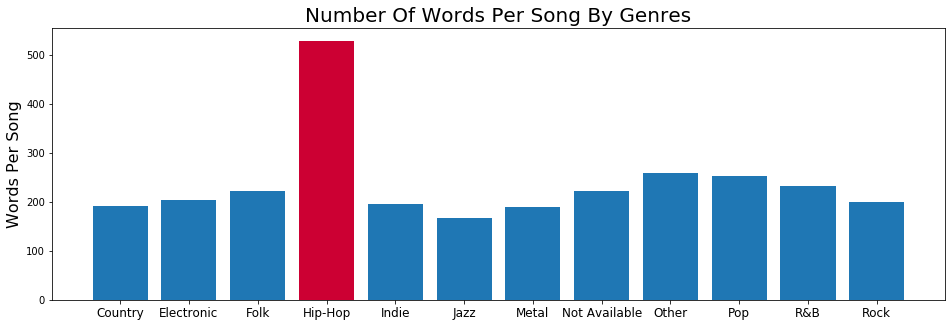

In [20]:
"""
Draw bar plot for the lyrics stats
"""
fig, axs = plt.subplots(1,1, figsize = (16,5))

colors = [ '#cc0033' if index == 'Hip-Hop' else '#1F77B4' for index in genre_song_stats.index]
draw_bar_for_wordcounts(axs, genre_song_stats['words_per_song'], 
                       genre_song_stats.index, params = {
                           'ylabel':'Words Per Song',
                           'title':'Number Of Words Per Song By Genres',
                           'color' : colors
                       })

### Part3 Lyrics Words Distribution

In [21]:
"""
Get the Unique words count , and words count for each genre
"""

def get_word_count_distribution(dataframe, by):
    """
    return a dictionary that stores the distribution of words count for all genres
    """
    classes = list(dataframe[by].unique())
    # store the distribution
    word_count_distribution = dict()
    # initialize
    for cla in classes:
        word_count_distribution[cla] = []
        
    # count
    for index, row in dataframe.iterrows():
        cate_name = row[by]
        raw_tokens = row['lyrics'].split()
        
        word_count_distribution[cate_name].append(len(raw_tokens))
    return word_count_distribution
    
genre_word_count_distribution = get_word_count_distribution(lyrics_df, 'genre')

In [22]:
def draw_boxplot_for_wordcounts(subplot, data, xlabels, ylabel, title):
    bp = subplot.boxplot(data)
    subplot.set_xticklabels(xlabels, fontsize= 12)
    subplot.set_ylabel(ylabel, fontsize = 16)
    subplot.set_title(title, fontsize = 20)
    
    for box in bp['boxes']:
        # change outline color
        box.set(color='#cccccc', linewidth=2)
#         help(box)#.set_facecolor('red')
#         box.
    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)


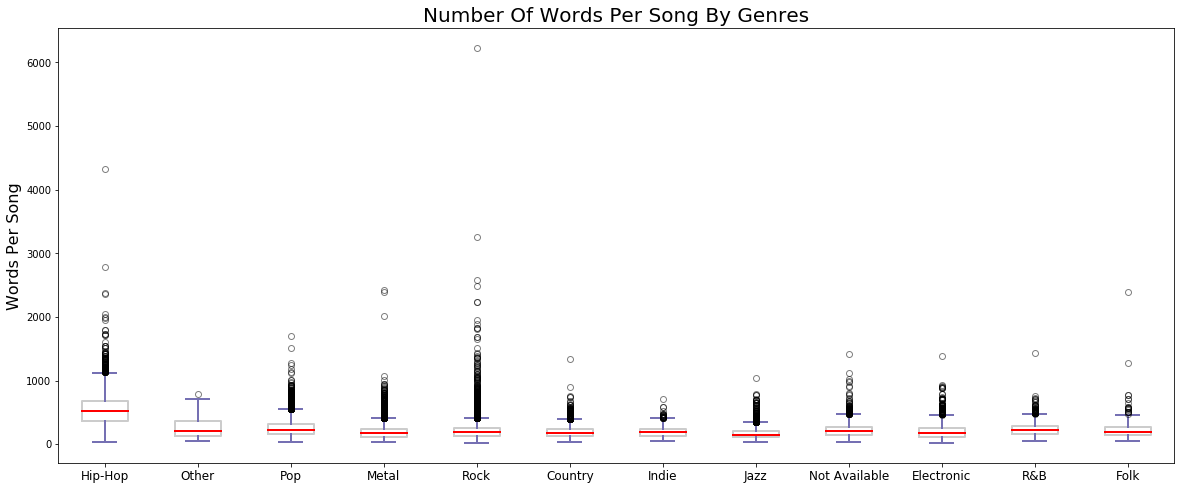

In [23]:
"""
draw boxplot for each genre
"""

fig, axs = plt.subplots(1,1, figsize= (20,8))
fig.subplots_adjust(hspace=.5) # adjust

# reformat input data
word_count_list = []
xlabels = []
for k,v in genre_word_count_distribution.items():
    word_count_list.append(genre_word_count_distribution[k]) 
    xlabels.append(k)
# draw boxplot
draw_boxplot_for_wordcounts(axs, word_count_list, xlabels, 'Words Per Song','Number Of Words Per Song By Genres')

### Part4. Profanity Word Frequency

In [24]:
"""
Count the amount of profane words
"""
def count_profanity(dataframe):
    """
    count how many profane words used in the input dataframe's lyrics
    """
    profane_dict = {}
    f_count = 0
    s_count = 0
    n_count = 0
    b_count = 0
    total_count = 0
    for index, row in dataframe.iterrows():
        if row['stemmedwords'].find('fuck') > -1:
            f_count += 1
        if row['stemmedwords'].find('nigga') > -1:
            n_count += 1
        if row['stemmedwords'].find('shit') > -1:
            s_count += 1
        if row['stemmedwords'].find('bitch') > -1:
            b_count += 1
        total_count += len(row['stemmedwords'].split())
    profane_dict['f_word']  = f_count
    profane_dict['s_word']  = s_count
    profane_dict['n_word']  = n_count
    profane_dict['b_word']  = b_count
    profane_dict['total']  = total_count
    return profane_dict

# get the profane word count
profanity_hiphop = count_profanity(hiphop_df)
profanity_non_hiphop = count_profanity(nonhiphop_df)

In [25]:
"""
Compare the number of profane words
"""
profanity_df = pd.DataFrame([profanity_hiphop, profanity_non_hiphop], index= ['hip-hop', 'non-hip-hop'])
profanity_df

,f_word,s_word,n_word,b_word,total
hip-hop,3286,4217,3169,2900,1743909
non-hip-hop,3753,3036,296,1210,7773669


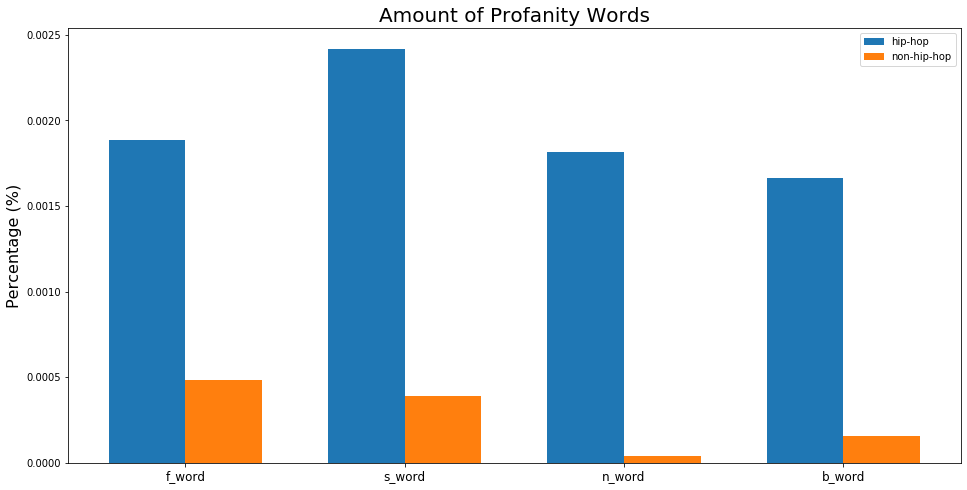

In [26]:
"""
Compare the percentage of profane words
"""
def draw_profanity_bar(profanity_df, labels):
    """
    """
    
    # calculate the percentages
    percentaged_profanity_df = profanity_df.apply(lambda row: row / row[-1], axis = 1)

    # plot the bar
    width = 0.35
    types = ['f_word','s_word','n_word','b_word']
    x = np.arange(len(percentaged_profanity_df.iloc[0,:-1]))
    plt.figure(figsize=(16,8))
    plt.bar(x-width/2, percentaged_profanity_df.iloc[0,:-1], width, label= labels[0])
    plt.bar(x+width/2, percentaged_profanity_df.iloc[1,:-1], width, label= labels[1])
    
    plt.ylabel('Percentage (%)', fontsize = 16)
    plt.title('Amount of Profanity Words', fontsize = 20)
    plt.xticks(x,labels = types, fontsize = 12)
    plt.legend()
    plt.show()
    
# draw the bar plot to compare
# plt_profanity_bar(profanity_df)
draw_profanity_bar(profanity_df, ['hip-hop', 'non-hip-hop'])

### Part5. Sentiment Analaysis

In [27]:
def get_sentiment(dataframe):
    """
    calculate all the sentiment of the dataframe's lyrics
    """
    polarity = []
    subjectivity = []
    for index, row in dataframe.iterrows():
        sentiments = TextBlob(row['lyrics']).sentiment
        polarity.append(sentiments.polarity)
        subjectivity.append(sentiments.subjectivity)
    return polarity, subjectivity

polarity_hiphop, subjectivity_hiphop  = get_sentiment(hiphop_df)
polarity_non_hiphop, subjectivity_non_hiphop  = get_sentiment(nonhiphop_df)

In [28]:
def draw_hist(subplot, data, params = {}):
    edgecolor = params.get('edgecolor', 'black')
    linewidth = params.get('linewidth', 1.2)
    title = params.get('title', None)
    ylabel = params.get('ylabel', None)
    xlabel = params.get('xlabel', None)
    color = params.get('color', None)
    xlim = params.get('xlim', None)
    subplot.hist(data, bins = 50, edgecolor='black', linewidth=linewidth, color = color)
    
    subplot.set_ylabel(ylabel, size = 16)
    subplot.set_xlabel(xlabel, size = 16)
    subplot.set_xlim(xlim)
    if title:
        subplot.set_title(title, size = 20)


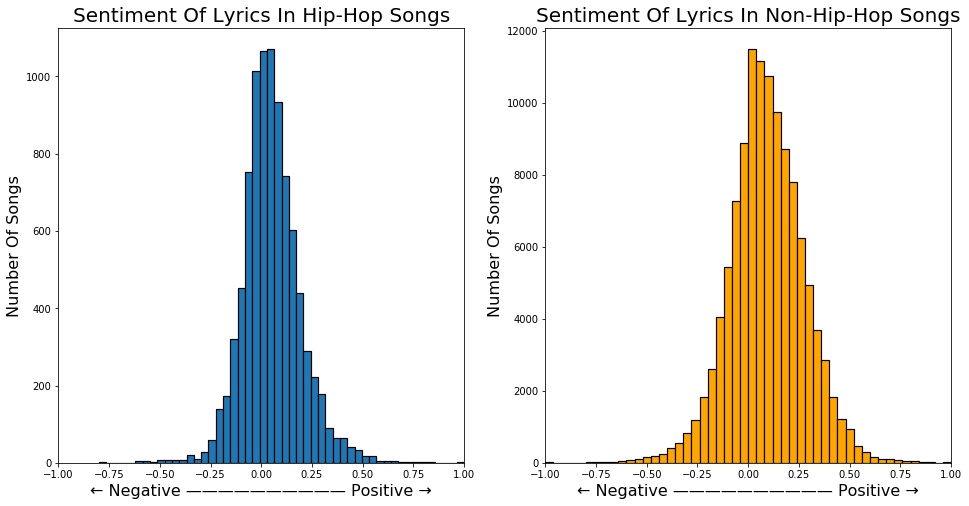

In [29]:
fig, axs = plt.subplots(1,2, figsize = (16,8))

draw_hist(axs[0], polarity_hiphop, params = {
    'title': 'Sentiment Of Lyrics In Hip-Hop Songs',
    'xlabel' : '← Negative —————————— Positive →',
    'ylabel' : 'Number Of Songs',
    'xlim' : [-1, 1]
})
draw_hist(axs[1], polarity_non_hiphop, params = {
    'title': 'Sentiment Of Lyrics In Non-Hip-Hop Songs',
    'xlabel' : '← Negative —————————— Positive →',
    'ylabel' : 'Number Of Songs',
    'color' : 'orange',
    'xlim' : [-1, 1]
})

plt.show()

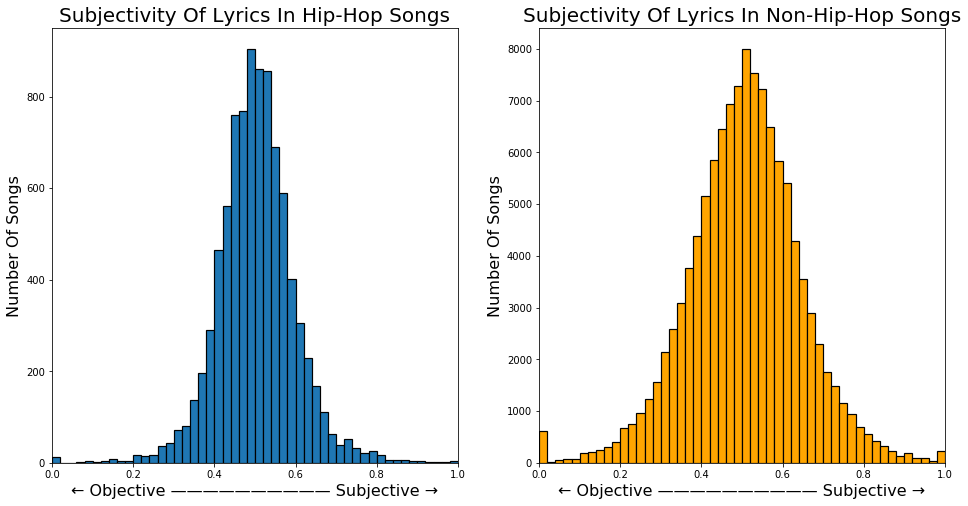

In [30]:
fig, axs = plt.subplots(1,2, figsize = (16,8))


draw_hist(axs[0], subjectivity_hiphop, params = {
    'title': 'Subjectivity Of Lyrics In Hip-Hop Songs',
    'xlabel' : '← Objective —————————— Subjective →',
    'ylabel' : 'Number Of Songs',
    'xlim' : [0, 1]
})
draw_hist(axs[1], subjectivity_non_hiphop, params = {
    'title': 'Subjectivity Of Lyrics In Non-Hip-Hop Songs',
    'xlabel' : '← Objective —————————— Subjective →',
    'ylabel' : 'Number Of Songs',
    'color' : 'orange',
    'xlim' : [0, 1]
})

plt.show()

## Question3. Is Eminem unique?

![](https://images-na.ssl-images-amazon.com/images/I/51WGb8pCIVL._SY679_.jpg)

### Part1. Most Common Words

In [31]:
"""
Split out different dataset
"""
hiphop_df = lyrics_df[lyrics_df['genre'] == 'Hip-Hop']

eminem_df = hiphop_df[hiphop_df['artist'] == 'eminem']
other_hiphop_df = hiphop_df[hiphop_df['artist'] != 'eminem']

In [32]:
"""
Get All Lyrics for Eminem and other hip-hop singers
"""

stemmed_lyrics_eminem = combine_lyrics(eminem_df)
stemmed_lyrics_other_hiphop = combine_lyrics(other_hiphop_df)

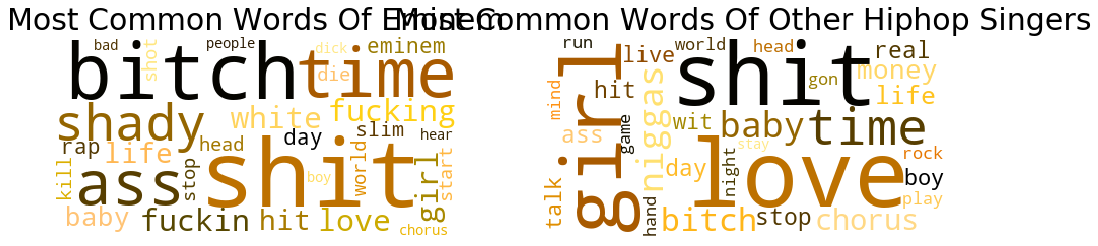

In [33]:
"""
Word cloud between Eminem and other Hip-Hop singers
"""
fig, axs = plt.subplots(1,2, figsize = (16,8))

draw_wordCloud(axs[0], stemmed_lyrics_eminem, params = {
        'title' : 'Most Common Words Of Eminem'
})
draw_wordCloud(axs[1], stemmed_lyrics_other_hiphop, params = {
  'title' : 'Most Common Words Of Other Hiphop Singers'  
} )
plt.show()

### Part2. Number Of Words 

In [34]:
hiphop_singer_stats = hiphop_df.groupby('artist').apply(get_song_stats)
hiphop_singer_stats = hiphop_singer_stats.reset_index(level=1, drop=True) # reset index

In [35]:
"""
Top 20 song_count hiphop singers
"""
hiphop_singer_stats_top20 = hiphop_singer_stats.sort_values('song_count', ascending=False)[:20]
hiphop_singer_stats_top20

,song_count,total_words_count,unique_count,words_per_song,unique_words_per_song
artist,,,,,
chris-brown,596,253620,5816,425.536913,9.758389
eminem,545,388159,12442,712.218349,22.829358
chamillionaire,354,209083,8435,590.629944,23.827684
busta-rhymes,261,163413,7893,626.103448,30.241379
dmx,249,148969,5191,598.269076,20.847390
atmosphere,240,118784,6719,494.933333,27.995833
bone-thugs-n-harmony,233,172229,5951,739.180258,25.540773
e-40,226,131665,8209,582.588496,36.323009
beastie-boys,201,66955,4717,333.109453,23.467662


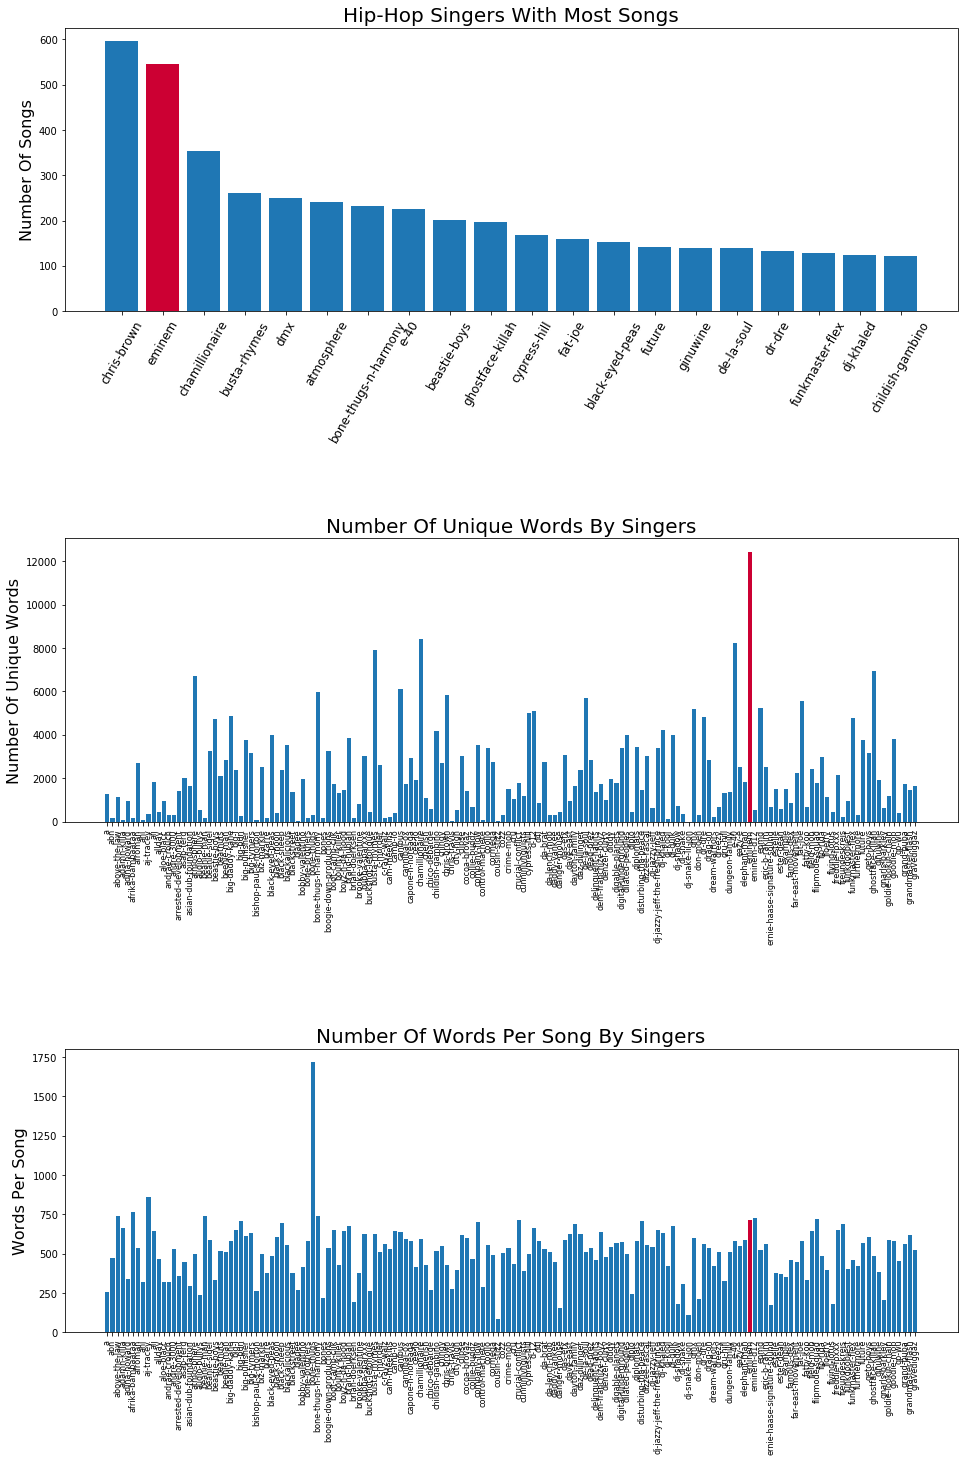

In [36]:
"""
Plot characteristics
"""
fig, axs = plt.subplots(3, 1, figsize = (16,24))
# adjust margin
fig.subplots_adjust(hspace=.8) 

# 1. plot number of songs
colors = [ '#cc0033' if index == 'eminem' else '#1F77B4' for index in hiphop_singer_stats_top20.index]
draw_bar_for_wordcounts(axs[0], hiphop_singer_stats_top20['song_count'], 
                        hiphop_singer_stats_top20.index, params = {
                            'ylabel' :'Number Of Songs',
                            'title': 'Hip-Hop Singers With Most Songs',
                            'color': colors,
                            'xrotation' : 60
                        })

# 2. plot unique words
colors = [ '#cc0033' if index == 'eminem' else '#1F77B4' for index in hiphop_singer_stats.index]
draw_bar_for_wordcounts(axs[1], hiphop_singer_stats['unique_count'], 
                        hiphop_singer_stats.index,  params = {
                            'ylabel' : 'Number Of Unique Words',
                            'xfontsize' : 8,
                            'title' : 'Number Of Unique Words By Singers',
                            'xrotation' : 90,
                            'color' :colors,
                        })



# 3. plot words per song
# set colors 
draw_bar_for_wordcounts(axs[2], hiphop_singer_stats['words_per_song'],
                        hiphop_singer_stats.index, params = {
                            'ylabel' : 'Words Per Song',
                            'title' : 'Number Of Words Per Song By Singers',
                            'xrotation' : 90,
                            'color' :colors,
                            'xfontsize': 8
                        })

plt.show()

### Part3. Amount of Profanity

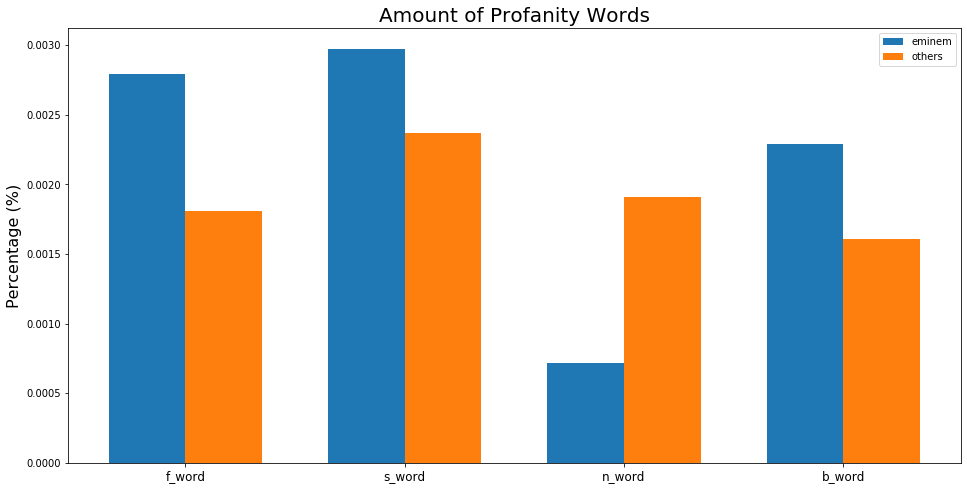

In [37]:
profanity_eminem =  count_profanity(eminem_df)
profanity_other_hiphop =  count_profanity(other_hiphop_df)
profanity_hiphop_df = pd.DataFrame([profanity_eminem, profanity_other_hiphop], index= ['eminem', 'others'])
draw_profanity_bar(profanity_hiphop_df, ['eminem', 'others'])

### Part4. Sentiment Analysis

In [38]:
polarity_eminem, subjectivity_eminem  = get_sentiment(eminem_df)
polarity_other_hiphop, subjectivity_other_hiphop  = get_sentiment(other_hiphop_df)

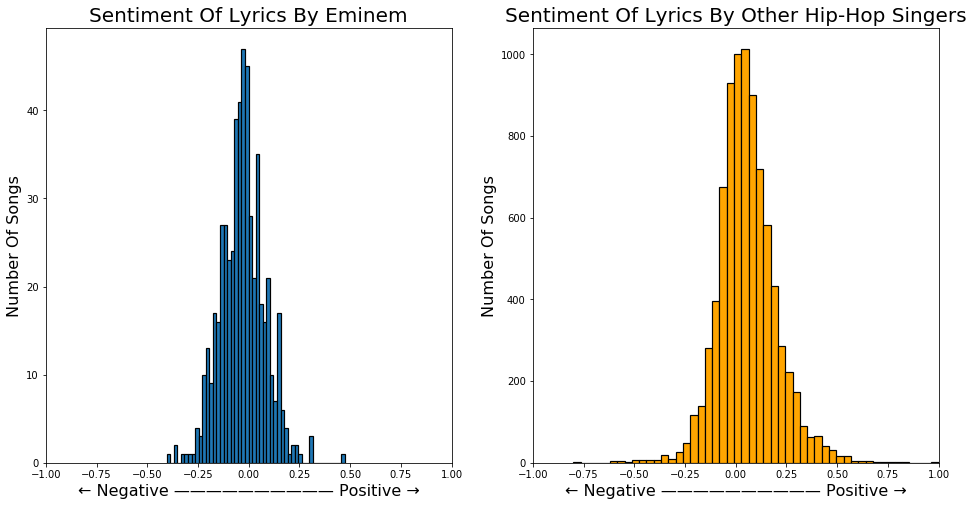

In [39]:
fig, axs = plt.subplots(1,2, figsize = (16,8))

draw_hist(axs[0], polarity_eminem, params = {
    'title': "Sentiment Of Lyrics By Eminem",
    'xlabel' : '← Negative —————————— Positive →',
    'ylabel' : 'Number Of Songs',
    'xlim' : [-1, 1]
})
draw_hist(axs[1], polarity_other_hiphop, params = {
    'title': "Sentiment Of Lyrics By Other Hip-Hop Singers",
    'xlabel' : '← Negative —————————— Positive →',
    'ylabel' : 'Number Of Songs',
    'color' : 'orange',
    'xlim' : [-1, 1]
})

plt.show()

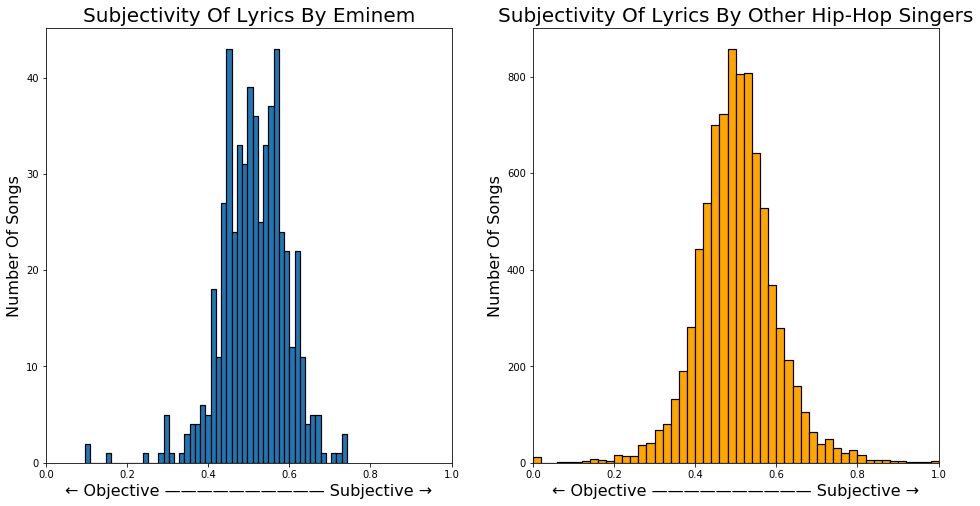

In [40]:
fig, axs = plt.subplots(1,2, figsize = (16,8))


draw_hist(axs[0], subjectivity_eminem, params = {
    'title': 'Subjectivity Of Lyrics By Eminem',
    'xlabel' : '← Objective —————————— Subjective →',
    'ylabel' : 'Number Of Songs',
    'xlim' : [0, 1]
})
draw_hist(axs[1], subjectivity_other_hiphop, params = {
    'title': 'Subjectivity Of Lyrics By Other Hip-Hop Singers',
    'xlabel' : '← Objective —————————— Subjective →',
    'ylabel' : 'Number Of Songs',
    'color' : 'orange',
    'xlim' : [0, 1]
})

plt.show()

## Conclusion